In [1]:
# 데이터 로딩
import pandas as pd
import os

os.chdir("C:/Users/401-09/Desktop/유전자_dl")
df = pd.read_csv("data/TF_input.csv")
print(df.shape)
print(df.columns[:10])
df.head()

(63, 18632)
Index(['Unnamed: 0', '15E1.2', '2'-PDE', '7A5', 'A1BG', 'A2BP1', 'A2M',
       'A2ML1', 'A3GALT2', 'A4GALT'],
      dtype='object')


,Unnamed: 0,15E1.2,2'-PDE,7A5,A1BG,A2BP1,A2M,A2ML1,A3GALT2,A4GALT,...,ZZZ3,bA16L21.2.1,bA9F11.1,dJ222E13.2,eIF2A,hCAP-D3,hCAP-H2,mimitin,psiTPTE22,raptor
0,3100083_Stroke,0.264796,-0.993720,1.311836,-0.449953,0.299290,-0.171909,-1.386964,-0.109468,-1.538368,...,-1.015975,-1.118698,0.275145,-0.486313,-0.968420,0.948740,0.364261,-0.589495,-0.828620,0.255998
1,3100191_Stroke,-1.655562,-0.920468,1.254974,1.160088,1.969535,-0.333171,1.459663,-0.178682,-0.153262,...,-0.350148,-1.851077,-0.558654,-0.991659,-1.315391,1.297689,-1.655779,-0.008901,-1.672563,-0.278169
2,3100068_Stroke,1.260273,-2.007904,-0.740763,-0.818691,-2.420044,0.232960,1.196944,0.735667,2.950623,...,-1.294807,-1.178315,0.732464,-0.257061,-0.431698,0.236757,-2.598921,-1.866173,1.584548,2.562095
3,3100060_Stroke,-0.555455,-0.955728,-0.744153,2.359199,-0.960852,-0.775154,1.519596,-0.538368,1.599964,...,-0.802067,-1.386907,-0.568032,-0.952378,0.420694,0.380534,-1.411813,-0.187836,-0.205303,0.769656
4,3100138_Stroke,-2.004888,0.202017,0.465204,-0.279563,0.831438,-0.621588,-0.472711,0.389695,-1.247356,...,-0.658673,-0.820424,-1.738871,-1.540441,-2.034253,-0.275462,-1.788697,-2.644954,-0.935344,1.305107


In [2]:
# 전처리
# 1. 라벨 분리
df[['SampleID', 'Label']] = df['Unnamed: 0'].str.split('_', expand = True)
df = df.drop(columns = ['Unnamed: 0'])

# 2. 특성과 라벨 분리
X = df.drop(columns = ['SampleID', 'Label'])
y = df['Label']
# 유전자 이름 저장
gene_names = X.columns.tolist()  

# 3. 결측치 확인
print("결측치 개수: ", X.isnull().sum().sum())

결측치 개수:  0


In [3]:
# 4. numpy 변환
X_np = X.values
y_np = y.values

In [4]:
"""
Input → Encoder(AE) → Latent vector → Transformer(Self-Attention) → Classifier
"""

'\nInput (B, N_genes)\n↓\nEncoder: MLP → Latent (B, L)\n↓\nReshape → (B, L, 1)\n↓\nTransformerEncoder (self-attn across latent dim)\n↓\nGlobalAveragePooling\n↓\nSigmoid output\n'

In [5]:
# 모델 구조 
import torch
import torch.nn as nn

class AETransformerLite(nn.Module):
    def __init__(self, input_dim, latent_dim=8, tf_embed_dim=8, dropout=0.2):
        super().__init__()

        # Encoder (AE part)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)  # Output: (B, latent_dim)
        )

        # Transformer embedding: reshape latent dim → sequence
        self.embedding = nn.Linear(1, tf_embed_dim)

        # Single-head Self-Attention (1-layer only)
        self.self_attn = nn.MultiheadAttention(embed_dim=tf_embed_dim, num_heads=1, dropout=dropout, batch_first=True)

        # FFN after attention (for classification)
        self.ffn = nn.Sequential(
            nn.LayerNorm(tf_embed_dim),
            nn.Linear(tf_embed_dim, 1),
            nn.Sigmoid()
        )

        # For interpretation
        self.attn_weights = None

    def forward(self, x):
        latent = self.encoder(x)              # (B, latent_dim)
        x = latent.unsqueeze(2)               # (B, latent_dim, 1)
        x = self.embedding(x)                 # (B, latent_dim, tf_embed_dim)

        # Attention block (no encoder layer wrapper)
        attn_out, attn_weights = self.self_attn(x, x, x, need_weights=True)
        self.attn_weights = attn_weights.detach().cpu()  # shape: (B, L, L)

        # Global average over sequence
        x = attn_out.mean(dim=1)              # (B, tf_embed_dim)

        out = self.ffn(x)                     # (B, 1)
        return out

In [6]:
# 데이터
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42, stratify=y_np
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor((y_train == "Stroke").astype(int), dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor((y_test == "Stroke").astype(int), dtype=torch.float32).unsqueeze(1)

In [7]:
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

In [8]:
# 학습 함수
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train(model, loader, optimizer, criterion, device, epochs=30):
    model.to(device)
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    epoch_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(loader)
        scheduler.step(avg_loss)  # ← 여기서 loss 보고 학습률 자동 조정

        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return epoch_losses

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AETransformerLite(input_dim=X_train_tensor.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

epoch_losses = train(model, train_loader, optimizer, criterion, device, epochs=200)

C:\Users\401-09\anaconda3\envs\dl_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200, Loss: 0.6364
Epoch 2/200, Loss: 0.3818
Epoch 3/200, Loss: 0.3221
Epoch 4/200, Loss: 0.3064
Epoch 5/200, Loss: 0.2959
Epoch 6/200, Loss: 0.2821
Epoch 7/200, Loss: 0.2858
Epoch 8/200, Loss: 0.2831
Epoch 9/200, Loss: 0.2785
Epoch 10/200, Loss: 0.2785
Epoch 11/200, Loss: 0.2827
Epoch 12/200, Loss: 0.2712
Epoch 13/200, Loss: 0.2693
Epoch 14/200, Loss: 0.2701
Epoch 15/200, Loss: 0.2688
Epoch 16/200, Loss: 0.2678
Epoch 17/200, Loss: 0.2627
Epoch 18/200, Loss: 0.2634
Epoch 19/200, Loss: 0.2645
Epoch 20/200, Loss: 0.2613
Epoch 21/200, Loss: 0.2641
Epoch 22/200, Loss: 0.2630
Epoch 23/200, Loss: 0.2601
Epoch 24/200, Loss: 0.2625
Epoch 25/200, Loss: 0.2544
Epoch 26/200, Loss: 0.2607
Epoch 27/200, Loss: 0.2560
Epoch 28/200, Loss: 0.2535
Epoch 29/200, Loss: 0.2561
Epoch 30/200, Loss: 0.2514
Epoch 31/200, Loss: 0.2524
Epoch 32/200, Loss: 0.2532
Epoch 33/200, Loss: 0.2468
Epoch 34/200, Loss: 0.2496
Epoch 35/200, Loss: 0.2487
Epoch 36/200, Loss: 0.2459
Epoch 37/200, Loss: 0.2433
Epoch 38/2

In [10]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor.to(device)).cpu().numpy().flatten()
    y_true = y_test_tensor.cpu().numpy().flatten()

y_pred = (y_pred_prob >= 0.5).astype(int)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_prob)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
spec = tn / (tn + fp)

print(f"Accuracy:     {acc:.4f}")
print(f"Precision:    {prec:.4f}")
print(f"Recall:       {rec:.4f} (Sensitivity)")
print(f"Specificity:  {spec:.4f}")
print(f"F1 Score:     {f1:.4f}")
print(f"AUC:          {auc:.4f}")

# 작은 데이터로 인한 과적합 가능성 있음

Accuracy:     0.8462
Precision:    1.0000
Recall:       0.7500 (Sensitivity)
Specificity:  1.0000
F1 Score:     0.8571
AUC:          0.9500


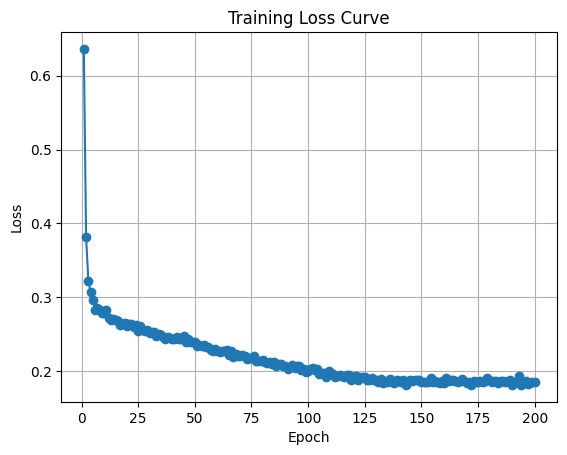

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

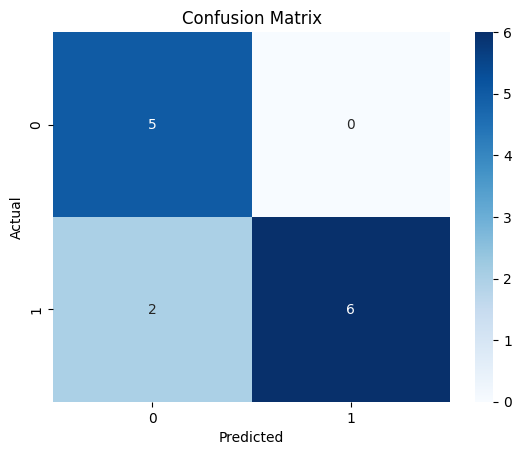

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
# FN 케이스 분리
import numpy as np

# 잘못 맞춘 FN 인덱스
fn_indices = np.where((y_true == 1) & (y_pred == 0))[0]
print("False Negative 인덱스:", fn_indices)

False Negative 인덱스: [ 1 11]


In [15]:
for idx in fn_indices:
    sample = X_test_tensor[idx].unsqueeze(0).to(device)
    _ = model(sample)

    attn_matrix = model.attn_weights.mean(dim=0)  # (latent_dim, latent_dim)
    latent_importance = attn_matrix.mean(dim=0).numpy()  # (latent_dim,)

    encoder_weights = model.encoder[2].weight.detach().cpu().numpy()  # (latent_dim, input_dim)
    gene_importance = np.abs(latent_importance[:, None] * encoder_weights).sum(axis=0)  # (input_dim,)

    top_idx = np.argsort(gene_importance)[::-1][:10]

    print(f"\n FN 케이스 {idx} → 유전자 중요도 Top10")
    for i in top_idx:
        print(f"{gene_names[i]}: {gene_importance[i]:.4f}")


 FN 케이스 1 → 유전자 중요도 Top10
ABCA1: 0.0897
AAA1: 0.0858
ABCB9: 0.0850
AACS: 0.0848
ABCA3: 0.0819
ABCA10: 0.0793
ABCA13: 0.0782
AATF: 0.0770
A4GNT: 0.0766
AASS: 0.0766

 FN 케이스 11 → 유전자 중요도 Top10
ABCB9: 0.0896
ABCA1: 0.0868
AACS: 0.0861
AAA1: 0.0856
ABCA3: 0.0838
AATF: 0.0788
A4GNT: 0.0771
ABCA12: 0.0771
AANAT: 0.0768
ABCA13: 0.0765


In [ ]:
# model_save.py
torch.save(model.state_dict(), "ae_transformer_lite.pt")